# Desafío 3: generación de secuencias por palabra

## Obtención y análisis del dataset

In [33]:
# Se importan librerías esenciales.

import os
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
# Si el dataset no se encuentra disponible, se scrappea desde la web y se almacena en el repositorio.

if os.access('./animal_farm.txt', os.F_OK) is False:
    
    urls = [
        'https://web.archive.org/web/20240407014849/http://www.george-orwell.org/Animal_Farm/0.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/1.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/2.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/3.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/4.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/5.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/6.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/7.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/8.html',
        'https://web.archive.org/web/20240407014848/http://www.george-orwell.org/Animal_Farm/9.html'
        ]

    book = ''

    for url in urls:
        chapter = scrap_text(url)
        book += chapter

    book_path = "./animal_farm.txt"

    with open(book_path, 'w', encoding='utf-8') as file:
        file.write(book)
else:
    pass

In [3]:
df = pd.read_csv('animal_farm.txt', sep='/n', header=None)
df

/tmp/ipykernel_9511/2144671484.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('animal_farm.txt', sep='/n', header=None)


0
0                                           Animal Farm
1                                             Chapter I
2     Mr. Jones, of the Manor Farm, had locked the h...
3     was too drunk to remember to shut the pop-hole...
4     from his lantern dancing from side to side, he...
...                                                 ...
2343  But what was it that seemed to be melting and ...
2344  But they had not gone twenty yards when they s...
2345  The source of the trouble appeared to be that ...
2346  Twelve voices were shouting in anger, and they...
2347                                             < Back

[2348 rows x 1 columns]

In [4]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 2348


## Preprocesamiento

In [5]:
# Se importan herramientas de preprocesamiento.

from tensorflow.keras.preprocessing.text import Tokenizer # Se utilizará para tokenizar.
from tensorflow.keras.preprocessing.text import text_to_word_sequence # Se utilizará para secuenciar.
from tensorflow.keras.utils import pad_sequences # Se utilizará para padding.


In [6]:
# Se guardan los documentos en una lista.

text = list(df.loc[:,0])
text

['Animal Farm',
 'Chapter I',
 'Mr. Jones, of the Manor Farm, had locked the hen-houses for the night, but',
 'was too drunk to remember to shut the pop-holes. With the ring of light',
 'from his lantern dancing from side to side, he lurched across the yard,',
 'kicked off his boots at the back door, drew himself a last glass of beer',
 'from the barrel in the scullery, and made his way up to bed, where',
 'Mrs. Jones was already snoring.',
 'As soon as the light in the bedroom went out there was a stirring and a',
 'fluttering all through the farm buildings. Word had gone round during the',
 'day that old Major, the prize Middle White boar, had had a strange dream',
 'on the previous night and wished to communicate it to the other animals.',
 'It had been agreed that they should all meet in the big barn as soon as',
 'Mr. Jones was safely out of the way. Old Major (so he was always called,',
 'though the name under which he had been exhibited was Willingdon Beauty)',
 'was so highly r

In [7]:
# Se segmenta cada documento.

segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [8]:
# Se visualizan las primeras 3 secuencias antes de segmentar.

text[0:3]

['Animal Farm',
 'Chapter I',
 'Mr. Jones, of the Manor Farm, had locked the hen-houses for the night, but']

In [9]:
# Se visualizan las primeras 3 secuencias luego de segmentar.

segmented_sentences[0:3]

[['animal', 'farm'],
 ['chapter', 'i'],
 ['mr',
  'jones',
  'of',
  'the',
  'manor',
  'farm',
  'had',
  'locked',
  'the',
  'hen',
  'houses',
  'for',
  'the',
  'night',
  'but']]

In [10]:
# Se calcula la longitud de cada secuencia.

length_sentences = [len(sentence) for sentence in segmented_sentences]

In [11]:
# Se visualiza la distribución de longitudes de secuencia.

plt.hist(length_sentences, bins=15)
plt.show()

Se observa que la gran mayoría de las secuencias tienen menos de 20 términos, por lo que se selecciona este número como longitud máxima de secuencia

In [12]:
max_context_size = 20

print(f'max_context_size: {max_context_size}')

max_context_size: 20


In [13]:
# Se tokenizan las secuencias. 

tok = Tokenizer()

tok.fit_on_texts(segmented_sentences)

tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [14]:
# Se visualiza la primer secuencia tokenizada.

tokenized_sentences[0]

[38, 23]

In [15]:
# Se visualiza la primer secuencia sin tokenizar.

segmented_sentences[0]

['animal', 'farm']

In [16]:
# Se divide el dataset en entrenamiento y validación.

tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

In [17]:
# Se acortan y agrupan las secuencias que tengan una longitud mayor a la máxima establecida.

tok_sent = []

for sent in tokenized_sentences_train:
  
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])

  else:
    tok_sent.append(sent)


In [18]:
# Se visualiza el nuevo total de secuencias.

len(tok_sent)

3032

In [19]:
# Se generan todas las subsecuencias posibles, y se paddean hasta la máxima longitud establecida.

tok_sent_augm = []

for sent in tok_sent:

  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [20]:
# Se concatenan todas las secuencias en un único array de numpy.
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [21]:
train_seqs.shape

(44376, 21)

In [22]:
# Se establecen entradas y targets. 

X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [23]:
y.shape

(44376, 20)

In [24]:
# Se visualizan las palabras del vocabulario.
tok.index_word

{1: 'the',
 2: 'and',
 3: 'of',
 4: 'to',
 5: 'was',
 6: 'a',
 7: 'in',
 8: 'had',
 9: 'that',
 10: 'it',
 11: 'they',
 12: 'he',
 13: 'were',
 14: 'his',
 15: 'for',
 16: 'on',
 17: 'animals',
 18: 'with',
 19: 'at',
 20: 'their',
 21: 'as',
 22: 'not',
 23: 'farm',
 24: 'but',
 25: 'all',
 26: 'be',
 27: 'been',
 28: 'them',
 29: 'napoleon',
 30: 'there',
 31: 'would',
 32: 'this',
 33: 'which',
 34: 'from',
 35: 'by',
 36: 'when',
 37: 'out',
 38: 'animal',
 39: 'snowball',
 40: 'no',
 41: 'said',
 42: 'pigs',
 43: 'have',
 44: 'who',
 45: 'is',
 46: 'i',
 47: 'now',
 48: 'up',
 49: 'one',
 50: 'you',
 51: 'him',
 52: 'boxer',
 53: 'time',
 54: 'could',
 55: 'an',
 56: 'work',
 57: 'more',
 58: 'windmill',
 59: 'two',
 60: 'or',
 61: 'so',
 62: 'squealer',
 63: 'other',
 64: 'after',
 65: 'down',
 66: 'we',
 67: 'what',
 68: 'every',
 69: 'did',
 70: 'even',
 71: 'jones',
 72: 'then',
 73: 'some',
 74: 'back',
 75: 'comrades',
 76: 'round',
 77: 'never',
 78: 'into',
 79: 'she',
 80

In [25]:
vocab_size = len(tok.word_counts)
print('Tamaño del vocabulario:', vocab_size)

Tamaño del vocabulario: 3968


In [26]:
# Se visualiza el índice para cada palabra, en orden descendente de popularidad.

print(tok.word_index)

{'the': 1, 'and': 2, 'of': 3, 'to': 4, 'was': 5, 'a': 6, 'in': 7, 'had': 8, 'that': 9, 'it': 10, 'they': 11, 'he': 12, 'were': 13, 'his': 14, 'for': 15, 'on': 16, 'animals': 17, 'with': 18, 'at': 19, 'their': 20, 'as': 21, 'not': 22, 'farm': 23, 'but': 24, 'all': 25, 'be': 26, 'been': 27, 'them': 28, 'napoleon': 29, 'there': 30, 'would': 31, 'this': 32, 'which': 33, 'from': 34, 'by': 35, 'when': 36, 'out': 37, 'animal': 38, 'snowball': 39, 'no': 40, 'said': 41, 'pigs': 42, 'have': 43, 'who': 44, 'is': 45, 'i': 46, 'now': 47, 'up': 48, 'one': 49, 'you': 50, 'him': 51, 'boxer': 52, 'time': 53, 'could': 54, 'an': 55, 'work': 56, 'more': 57, 'windmill': 58, 'two': 59, 'or': 60, 'so': 61, 'squealer': 62, 'other': 63, 'after': 64, 'down': 65, 'we': 66, 'what': 67, 'every': 68, 'did': 69, 'even': 70, 'jones': 71, 'then': 72, 'some': 73, 'back': 74, 'comrades': 75, 'round': 76, 'never': 77, 'into': 78, 'she': 79, 'than': 80, 'day': 81, 'came': 82, 'dogs': 83, 'before': 84, 'her': 85, 'any': 86

In [27]:
# Se visualiza la cantidad de veces que aparece cada palabra en cada "documento".
print(tok.word_docs)

defaultdict(<class 'int'>, {'animal': 108, 'farm': 170, 'chapter': 10, 'i': 65, 'locked': 1, 'jones': 55, 'but': 173, 'manor': 8, 'mr': 41, 'the': 1411, 'hen': 3, 'houses': 2, 'night': 25, 'had': 456, 'of': 764, 'for': 244, 'shut': 3, 'holes': 4, 'to': 701, 'pop': 1, 'with': 223, 'was': 542, 'light': 9, 'too': 35, 'ring': 2, 'drunk': 2, 'remember': 14, 'lantern': 3, 'his': 247, 'side': 26, 'across': 7, 'dancing': 1, 'from': 124, 'yard': 25, 'lurched': 1, 'he': 275, 'last': 27, 'a': 531, 'boots': 3, 'drew': 4, 'himself': 34, 'kicked': 5, 'door': 10, 'off': 30, 'glass': 4, 'at': 196, 'back': 53, 'beer': 6, 'where': 27, 'in': 491, 'barrel': 2, 'and': 841, 'scullery': 2, 'way': 33, 'made': 40, 'up': 83, 'bed': 14, 'already': 19, 'snoring': 1, 'mrs': 5, 'stirring': 3, 'out': 115, 'as': 165, 'soon': 20, 'there': 137, 'bedroom': 4, 'went': 29, 'round': 46, 'through': 25, 'word': 12, 'gone': 14, 'buildings': 17, 'fluttering': 3, 'all': 171, 'during': 9, 'old': 43, 'boar': 4, 'day': 50, 'white'

## Entrenamiento de modelos

In [28]:
# Se crea una función para registrar la perplejidad durante el entrenamiento 
# y establecer un criterio de detención.

class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad 
    de la generación de secuencias. Además implementa la finalización 
    del entrenamiento (Early Stopping) si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):

      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      for seq in self.val_data:

        len_seq = len(seq)
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        for start,end in self.info:

          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

### Modelo original

In [29]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100, return_sequences=True))

model.add(Dense(vocab_size+1, activation='softmax'))

model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/home/nata/Documentos/Git/nlp/.venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 50)       │       198,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 100)      │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 100)      │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 3969)     │       400,869 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 740,119 (2.82 MB)

 Trainable params: 740,119 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20


694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 3.9895

2024-07-20 03:28:50.575449: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1888608960 exceeds 10% of free system memory.



 mean perplexity: 5443.085020541115 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 116s 163ms/step - loss: 3.9886
Epoch 2/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2.9996

2024-07-20 03:30:38.957122: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1888608960 exceeds 10% of free system memory.



 mean perplexity: 14595.221420109485 

694/694 ━━━━━━━━━━━━━━━━━━━━ 108s 156ms/step - loss: 2.9996
Epoch 3/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 2.9702

2024-07-20 03:32:28.010053: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1888608960 exceeds 10% of free system memory.



 mean perplexity: 5810.991665397061 

694/694 ━━━━━━━━━━━━━━━━━━━━ 109s 157ms/step - loss: 2.9701
Epoch 4/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2.8266

2024-07-20 03:34:15.616644: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1888608960 exceeds 10% of free system memory.



 mean perplexity: 5144.7853123040595 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - loss: 2.8265
Epoch 5/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2.6890

2024-07-20 03:36:03.044753: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1888608960 exceeds 10% of free system memory.



 mean perplexity: 3551.4101172032883 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 107s 155ms/step - loss: 2.6890
Epoch 6/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.5723
 mean perplexity: 3148.989196145348 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 107s 154ms/step - loss: 2.5723
Epoch 7/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - loss: 2.5081
 mean perplexity: 2938.7666432498004 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 107s 154ms/step - loss: 2.5081
Epoch 8/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 2.4383
 mean perplexity: 2875.1374853310017 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 108s 155ms/step - loss: 2.4383
Epoch 9/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - loss: 2.3841
 mean perplexity: 2782.321200101247 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 103s 148ms/step - loss: 2.3841
Epoch 10/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - loss: 2.3240
 mean perplexity: 2660.9275347267335 

Saved new model!
694/694 ━━━━━━━━━━━

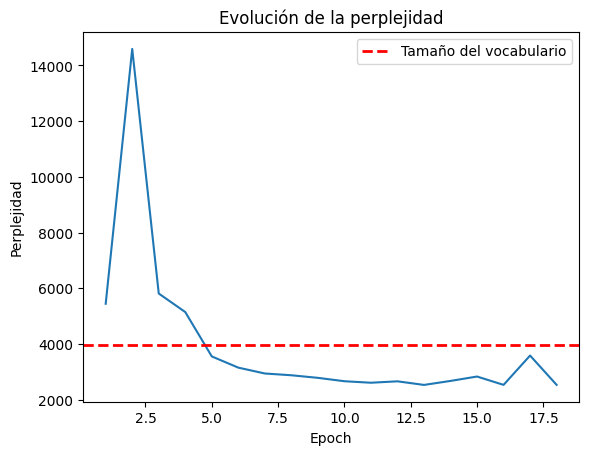

In [31]:
# Se grafica la evolución de la perplejidad con las épocas.

import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(history_ppl) + 1)

ax = sns.lineplot(x=epoch_count,  y=history_ppl)
ax.axhline(y=vocab_size, color='r', linestyle='--', linewidth=2, label='Tamaño del vocabulario')

ax.set_title('Evolución de la perplejidad')
ax.set_ylabel('Perplejidad')
ax.set_xlabel('Epoch')
ax.legend()

plt.show()

### Modelo alternativo propuesto

Se ha decidido convertir las capas `LSTM` en bidireccionales, a fin de poder obtener información del contexto entero. Además, se han agregado capas de `Dropout` y `BatchNormalization` con el objetivo de volver más estable el entrenamiento a la vez de agregar regularización.

In [34]:
alt_model = Sequential()

alt_model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

alt_model.add(Bidirectional(LSTM(30, return_sequences=True)))
alt_model.add(BatchNormalization())
alt_model.add(Dropout(0.5))

alt_model.add(Bidirectional(LSTM(30, return_sequences=True)))
alt_model.add(BatchNormalization())
alt_model.add(Dropout(0.5))

alt_model.add(Dense(vocab_size+1, activation='softmax'))

alt_model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

alt_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, None, 50)       │       198,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 60)       │        19,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, None, 60)       │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, None, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 60)       │        21,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, None, 60)       │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, None, 3969)     │       242,109 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 482,319 (1.84 MB)

 Trainable params: 482,079 (1.84 MB)

 Non-trainable params: 240 (960.00 B)

In [35]:
alt_history_ppl = []
hist = alt_model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val, alt_history_ppl)], batch_size=64)

Epoch 1/20
693/694 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 3.9639
 mean perplexity: 1385.669398303058 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 85s 116ms/step - loss: 3.9604
Epoch 2/20
693/694 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 1.5263
 mean perplexity: 1215.579520627122 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 85s 122ms/step - loss: 1.5259
Epoch 3/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 1.0727
 mean perplexity: 1023.177788161597 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 88s 127ms/step - loss: 1.0726
Epoch 4/20
694/694 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.8705
 mean perplexity: 940.5253295628704 

Saved new model!
694/694 ━━━━━━━━━━━━━━━━━━━━ 81s 116ms/step - loss: 0.8705
Epoch 5/20
693/694 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.7719
 mean perplexity: 1016.2514161071141 

694/694 ━━━━━━━━━━━━━━━━━━━━ 80s 115ms/step - loss: 0.7719
Epoch 6/20
693/694 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.7145
 mean perplexity: 872.90317322206

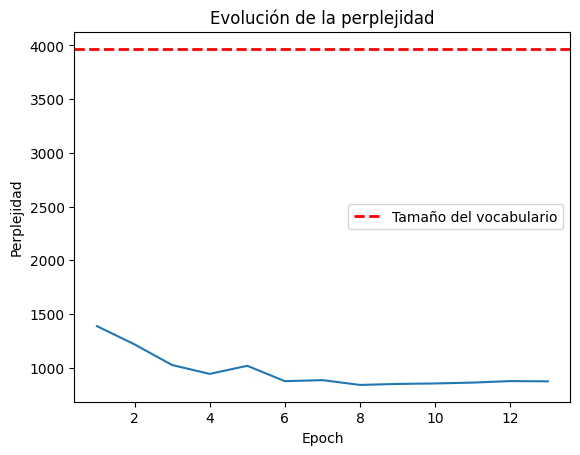

In [42]:
# Se grafica la evolución de la perplejidad con las épocas.

import matplotlib.pyplot as plt
import seaborn as sns

epoch_count = range(1, len(alt_history_ppl) + 1)

ax = sns.lineplot(x=epoch_count, y=alt_history_ppl)
ax.axhline(y=vocab_size, color='r', linestyle='--', linewidth=2, label='Tamaño del vocabulario')

ax.set_title('Evolución de la perplejidad')
ax.set_ylabel('Perplejidad')
ax.set_xlabel('Epoch')
ax.legend()

plt.show()

Se observa que este modelo presenta una perplejidad mucho más baja.

## Evaluación del modelo

In [43]:
# Se carga el mejor modelo.
model = keras.models.load_model('my_model.keras')

### Predicción de la siguiente palabra

In [44]:
# Se utiliza la librería Gradio para generar predicciones de la próxima palabra.

import gradio as gr

def model_response(human_text):

    encoded = tok.texts_to_sequences([human_text])[0]

    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    y_hat = np.argmax(model.predict(encoded)[0,-1,:])

    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

/home/nata/Documentos/Git/nlp/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Keyboard interruption in main thread... closing server.


Se observa que el modelo arroja resultados semánticamente correctos.

### Predicción de las siguientes _n_ palabras

In [45]:
# En este caso se predicen las próximas n palabras.

def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text

    for _ in range(n_words):

      encoded = tokenizer.texts_to_sequences([output_text])[0]

      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      out_word = ''

      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

      output_text += ' ' + out_word

    return output_text

In [103]:
input_text='The animal farm'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=30)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

'The animal farm had been regarded he had been regarded he had been enjoying a game of the farm had been enjoying a game of the farm had been enjoying a game of'

Se observa que el modelo entra en un loop del que le es imposible salir.

###  Beam search

In [54]:
# Se definen funciones para codificar y decodificar textos.

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [56]:
# Se crean funciones para realizar beam search determinístico y estocástico.

from scipy.special import softmax

def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams]
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp))
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    encoded = encode(input)

    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    vocab_size = y_hat.shape[0]

    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        input_update = np.array([hist[i+1:]]).copy()

        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

Se infiere con **beam search determinístico.**

In [104]:
beam_det_output = beam_search(
    model,
    num_beams=10,
    num_words=15,
    input="The animal farm",
    mode='det')

In [105]:
decode(beam_det_output[9])

['the animal farm had been enjoying a game of the company had been enjoying a game of course']

Al explorar las distintas salidas, se observa que el modelo logra trazar nuevos caminos para llegar a distintos resultados, pero todos similares entre sí.

Se infiere con **beam search estocástico y baja temperatura.**

In [109]:
beam_sto_low_t = beam_search(
    model,
    num_beams=10,
    num_words=15,
    input="The animal farm",
    temp=0.5,
    mode='sto')

In [111]:
decode(beam_sto_low_t[0])

['the animal farm had been regarded he had been enjoying a game of the company had been born']

Como era de esperar, con baja temperatura el modelo genera un texto similar que con beam search determinístico.

Se infiere con **beam search estocástico y alta temperatura.**

In [133]:
beam_sto_high_t = beam_search(
    model,
    num_beams=10,
    num_words=15,
    input="The animal farm",
    temp=1.5,
    mode='sto')

In [134]:
decode(beam_sto_high_t[0])

['the animal farm they brainworkers to especially at the pigs who down the most up to dangerous is']

Si bien los resultados que se obtienen son semánticamente mejorables, se observa una mucho mejor capacidad de generar secuencias nuevas.